<h1 style="text-align:center;font-size:36px;font-weight:bold;">How to become a correlation wizard with the brightwind library!</h1>

In [3]:
import datetime
print('Last updated: {}'.format(datetime.date.today().strftime('%d %B, %Y')))

Last updated: 15 October, 2024


<hr class="gray-line">
<font size="6">Outline:</font>

This guide will demonstrate various techniques to correlate a sample site dataset to 4 separate reference datasets using the following steps:

• Import the brightwind library, load some sample raw data and clean it

• Import 4 sample reference datasets to use in the correlation

• Perform a ordinary least squares correlation for 1 dataset and time period

• Apply a long term adjustment to the measured wind speed time series based on the correlation results

• Perform a ordinary least squares correlation for multiple datasets and time periods

<hr class="gray-line">
<font size="6">Import brightwind and data</font>

In [5]:
# import the brightwind library
import brightwind as bw

In [7]:
# specify the directory of the demo dataset
filepath = r'E:\Programs\brightwind\brightwind\demo_datasets\demo_data.csv'
# load the raw data
data = bw.load_csv(filepath)
# apply cleaning to the raw data
data = bw.apply_cleaning(data, r'E:\Programs\brightwind\brightwind\demo_datasets\demo_cleaning_file.csv')
# show the first 5 rows of the cleaned data
data.head(5)

,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir78mSStd,Dir58mS,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,4.680,118.8,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,3.123,115.9,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69


<hr class="gray-line">
<font size="6">Import reference datasets</font>

For this example, we will import 4 MERRA-2 reanalysis datasets. These can be found as sample datasets within the brightwind library. We use the load_csv() function to load in each dataset from a csv file.

In [9]:
# load each of the 4 reanalysis datasets to its own dataframe
Merra2_NE =  bw.load_csv(r'E:\Programs\brightwind\brightwind\demo_datasets\MERRA-2_NE_2000-01-01_2017-06-30.csv')
Merra2_NW =  bw.load_csv(r'E:\Programs\brightwind\brightwind\demo_datasets\MERRA-2_NW_2000-01-01_2017-06-30.csv')
Merra2_SE =  bw.load_csv(r'E:\Programs\brightwind\brightwind\demo_datasets\MERRA-2_SE_2000-01-01_2017-06-30.csv')
Merra2_SW =  bw.load_csv(r'E:\Programs\brightwind\brightwind\demo_datasets\MERRA-2_SW_2000-01-01_2017-06-30.csv')

# show the first 5 lines of NE dataset
Merra2_NE.head(5)

,WS50m_m/s,WD50m_deg,T2M_degC,PS_hPa
DateTime,,,,
2000-01-01 00:00:00,6.840,275,4.06,997.17
2000-01-01 01:00:00,6.506,264,3.44,997.64
2000-01-01 02:00:00,7.095,254,3.12,998.39
2000-01-01 03:00:00,8.088,246,3.19,999.12
2000-01-01 04:00:00,8.386,239,3.18,999.61


In [10]:
Merra2_NE

,WS50m_m/s,WD50m_deg,T2M_degC,PS_hPa
DateTime,,,,
2000-01-01 00:00:00,6.840,275,4.06,997.17
2000-01-01 01:00:00,6.506,264,3.44,997.64
2000-01-01 02:00:00,7.095,254,3.12,998.39
2000-01-01 03:00:00,8.088,246,3.19,999.12
2000-01-01 04:00:00,8.386,239,3.18,999.61
...,...,...,...,...
2017-06-30 19:00:00,2.456,356,13.87,993.21
2017-06-30 20:00:00,1.982,335,13.09,993.78
2017-06-30 21:00:00,1.802,313,12.72,994.00


<hr class="gray-line">
<font size="6">Correlate to 1 dataset and using 1 averaging period</font>

Next we’ll perform a basic linear regression correlation using the Ordinary Least Squares method between the 80m north orientated site anemometer and the MERRA-2 dataset located to the North East. We use the ‘averaging_prd’ argument to set the averaging period for which the correlation should be carried out. This can be set to 10-min or multiples of ten minutes (10T, 30T) (depending on the interval of both datasets), hourly or multiples of 1 hour (1H, 2H, 3H, etc), daily or multiples of 1 day (1D, 2D, 3D, 15D, etc), monthly (1M) or yearly (1AS). Here we apply a monthly correlation. Finally we set the ‘coverage_threshold’, this is the minimum coverage of data within each averaging period from both the reference and site dataset that will be passed to the correlation. In this case we use a coverage threshold of 90%.

In [11]:
# set up correlation
ord_lst_sq = bw.Correl.OrdinaryLeastSquares(Merra2_NE['WS50m_m/s'], data['Spd80mN'],
                                            averaging_prd='1M', coverage_threshold=0.90)

The correlation function returns a python object. This has to be subsequently run and plotted using the commands run() and plot().

In [12]:
# run correlation
ord_lst_sq.run()

{'num_data_points': 16,
 'offset': -0.03654377973981284,
 'r2': 0.9432508472241504,
 'slope': 0.9935701446930347}


To show the correlation plot along with the linear regression line we simply input:

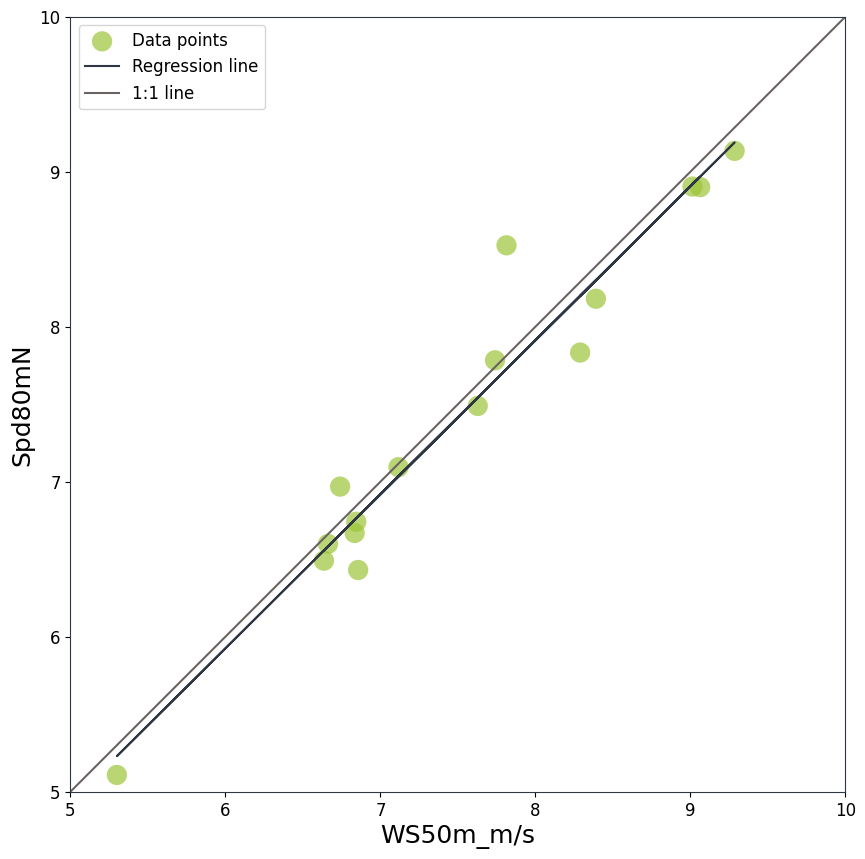

In [13]:
# show plot
ord_lst_sq.plot()

Now that we have a correlation we will want to adjust our data accordingly. We can synthesize monthly Spd80mN mean wind speeds from the Merra2_NE data using the synthesize() method. This will synthesize monthly means for months that Spd80mN doesn’t cover and splices it with months Spd80mN does cover.

In [14]:
# synthesize monthly means over the long term record
LT_monthly_means = ord_lst_sq.synthesize()
# Show the first 5 values
LT_monthly_means.head(5)

,Spd80mN_Synthesized
2000-01-01,9.307369
2000-02-01,11.101957
2000-03-01,8.008957
2000-04-01,6.853666
2000-05-01,6.203680


<hr class="gray-line">
<font size="6">Apply a long term adjustment to the measured wind speed time series based on the correlation results</font>

We can use the results of the above correlation to rescale the Spd80mN wind speed time series and put it into a long term context. First we’ll use the momm() (mean of monthly means) function to derive the long term mean of the dataset we synthesized above. This represents our target long term mean speed.

In [16]:
# derive long term target mean speed
LT_target_speed = bw.momm(LT_monthly_means)
# show the value
LT_target_speed

7.630871250351322

Next, we’ll derive a scale factor we can apply to the measurements to achieve this long term mean.

In [18]:
# derive scale factor as ratio of means
LT_scale_factor = LT_target_speed/data.Spd80mN.mean()
# show the value
LT_scale_factor

1.0149275930067623

Then, we can use the scale_wind_speed() function to rescale the measurements based on the above factor, placing them in a long term context. We’ll also allocate this a new variable within the existing dataframe.

In [19]:
# scale wind speed
data['Spd80mN_LT'] = bw.scale_wind_speed(data.Spd80mN, LT_scale_factor)
# show first 5 timestamps. The new variable can be seen in the last column of the dataframe.
data.head(5)

,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir58mS,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin,Spd80mN_LT
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,118.8,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71,7.492195
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,115.9,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69,8.096077


Now, let’s confirm that the mean of our new variable is equal to our long term mean speed target.

In [20]:
# show ratio of mean values
data.Spd80mN_LT.mean()/LT_target_speed

0.9999999999999999

The resulting variable can then be used along with concurrent wind direction data (such as ‘data.Dir78mS’) to generate a tab file for wind flow modelling as shown in the tutorial for exporting a tab file.

<style>
.gray-line {
  border-top: 1px solid gray;
  margin-top: -10px;
}
</style>

<hr class="gray-line">
<font size="6">Correlation for multiple datasets and time periods</font>

<font size="3">Note:</font> in a future release we plan to create a more user-friendly wrapper to perform multiple correlations at once.

As well as performing one correlation with specific parameters, the brightwind library can be used to correlate to multiple reference datasets using multiple averaging periods in one cell. The code below performs two ‘for’ loops to iterate through each of the MERRA-2 datasets and a number of averaging periods, and returns the results in a dataframe. In order to allocate the results as a dataframe, we need to first import the pandas library.

In [23]:
import pandas as pd

We then assign each of the datasets to a python dictionary, so we can easily loop through them later.

In [24]:
merra2_nodes = {
    'M2_NE': Merra2_NE,
    'M2_NW': Merra2_NW,
    'M2_SE': Merra2_SE,
    'M2_SW': Merra2_SW
}

The following code can then be used to run each for loop and add results to the new dataframe. Specific steps are explained in the comments throughout.

In [29]:
# set the target and reference column names
target_column = 'Spd80mN'
ref_column = 'WS50m_m/s'

# create a list to store all of the results
correl_results = []

# set up first loop, which will step through the 4 reanalysis datasets
for node in merra2_nodes:
    # set up the second loop, nested within the first one. This one will step through a number of averaging periods.
    for avg_prd in ['1D','3D','7D','15D','1M']:

        # set up the correlation object, as done previously
        ord_lst_sq = bw.Correl.OrdinaryLeastSquares(merra2_nodes[node][ref_column], data[target_column],
                                                    averaging_prd=avg_prd, coverage_threshold=0.90)
        # run the correlation
        ord_lst_sq.run()

        # Append the results to the results list
        correl_results.append({
            '1, Reanalysis dataset': node,
            '2, Averaging Period': avg_prd,
            '3, Num data points': ord_lst_sq.params['num_data_points'],
            '4, LT Reference MOMM': bw.momm(merra2_nodes[node][ref_column]),
            '5, R^2': ord_lst_sq.params['r2'],
            '6, Slope': ord_lst_sq.params['slope'],
            '7, Offset': ord_lst_sq.params['offset'],
            '8, LT Target wind speed': bw.momm(ord_lst_sq.synthesize()),
            '9, Adjustment of mean [%]': ((bw.momm(ord_lst_sq.synthesize()) / data[target_column].mean())-1)*100,
        })

{'num_data_points': 509,
 'offset': -0.425364309709117,
 'r2': 0.8950523105464153,
 'slope': 1.0404087736405052}
{'num_data_points': 168,
 'offset': -0.6504302636848669,
 'r2': 0.9344850185603071,
 'slope': 1.0671585014880924}
{'num_data_points': 71,
 'offset': -0.5997570992858663,
 'r2': 0.9336779525935,
 'slope': 1.0635678045188734}
{'num_data_points': 34,
 'offset': -0.35451128248704095,
 'r2': 0.9584503584233884,
 'slope': 1.0332061758200222}
{'num_data_points': 16,
 'offset': -0.03654377973981284,
 'r2': 0.9432508472241504,
 'slope': 0.9935701446930347}
{'num_data_points': 509,
 'offset': -0.09624436054557202,
 'r2': 0.8467980268670572,
 'slope': 0.9514007868792314}
{'num_data_points': 168,
 'offset': -0.3221201816298373,
 'r2': 0.895354192380868,
 'slope': 0.9777718777567072}
{'num_data_points': 71,
 'offset': -0.2823633290715707,
 'r2': 0.8909865639079158,
 'slope': 0.9750154834855431}
{'num_data_points': 34,
 'offset': 0.1280932683192656,
 'r2': 0.922796311949747,
 'slope': 0.9

Each set of print results above are the result of the obj.run() function. We have saved a summary of the results under ‘correl_results’, so lets take a look at that now.

In [30]:
# put the list into a DataFrame for ease of analysis.
correl_results_df = pd.DataFrame(correl_results)
correl_results_df

,"1, Reanalysis dataset","2, Averaging Period","3, Num data points","4, LT Reference MOMM","5, R^2","6, Slope","7, Offset","8, LT Target wind speed","9, Adjustment of mean [%]"
0,M2_NE,1D,509,7.707068,0.895052,1.040409,-0.425364,7.600746,1.092083
1,M2_NE,3D,168,7.707068,0.934485,1.067159,-0.650430,7.582887,0.854553
2,M2_NE,7D,71,7.707068,0.933678,1.063568,-0.599757,7.605013,1.148834
3,M2_NE,15D,34,7.707068,0.958450,1.033206,-0.354511,7.621406,1.366873
4,M2_NE,1M,16,7.707068,0.943251,0.993570,-0.036544,7.630871,1.492759
5,M2_NW,1D,509,8.114629,0.846798,0.951401,-0.096244,7.630938,1.493653
6,M2_NW,3D,168,8.114629,0.895354,0.977772,-0.322120,7.619768,1.345087
7,M2_NW,7D,71,8.114629,0.890987,0.975015,-0.282363,7.636852,1.572310
8,M2_NW,15D,34,8.114629,0.922796,0.924453,0.128093,7.642041,1.641326
9,M2_NW,1M,16,8.114629,0.882998,0.863707,0.631497,7.649689,1.743037


We can easily scan down through the results to see the different [Math Processing Error]
 values for different averaging periods and reanalysis datasets, and see other key metrics such as the predicted long term wind speed and the percentage adjustment from the measured site wind speed to the long term wind speed.

Now lets scale the wind speed once again, this time based on the correlation with the highest [Math Processing Error]
 value in our table. First, let’s show all the parameters of the correlation with the max [Math Processing Error].

In [31]:
# show correlation results when r2 is equal to the max r2
correl_results_df[correl_results_df['5, R^2'] == max(correl_results_df['5, R^2'])]

,"1, Reanalysis dataset","2, Averaging Period","3, Num data points","4, LT Reference MOMM","5, R^2","6, Slope","7, Offset","8, LT Target wind speed","9, Adjustment of mean [%]"
3,M2_NE,15D,34,7.707068,0.95845,1.033206,-0.354511,7.621406,1.366873


We can pull out the index of this correlation from our table by adding on .index[0] on the end amd assigning it to a variable.

In [32]:
# get row with the best correlation
row = correl_results_df[correl_results_df['5, R^2'] == max(correl_results_df['5, R^2'])].index[0]
# show index
row

3

Then we can refer to the long term target speed from this correlation as follows.

In [33]:
correl_results_df['8, LT Target wind speed'][row]

7.621406309808873

This can be used to derive a scale factor in the same way we did before.

In [34]:
# derive scale factor as ratio of means
LT_scale_factor = correl_results_df['8, LT Target wind speed'][row] / data[target_column].mean()
# show the value
LT_scale_factor

1.0136687289783255

Finally, we can create a second LT adjusted time series using the same commands as before, once again add this to our existing DataFrame alongside the previous long term variable.

In [35]:
# scale wind speed
data['Spd80mN_LT_2'] = bw.scale_wind_speed(data[target_column], LT_scale_factor)
# show first 5 timestamps. The new variable can be seen to the right of the dataframe.
data.head(5)

,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin,Spd80mN_LT,Spd80mN_LT_2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71,7.492195,7.482903
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69,8.096077,8.086035


Of course, [Math Processing Error]
 is not the only parameter than matters when deciding on a robust correlation method, so the analyst still has an important role! Nonetheless, this shows how easy the library makes it to compare large numbers of reference datasets and get back useful results fast. Upcoming updates to the library will aim to reduce the code required to perform the looping procedure, so watch this space!

<font size="6">Other correlation methods</font>

The library also includes a host of other correlation functions such as:

<span style="color:white;">•</span><u style="color:red;">SimpleSpeedRatio()</u>

<span style="color:white;">•</span><u style="color:red;">OrthogonalLeastSquares()</u>

<span style="color:white;">•</span><u style="color:red;">MultipleLinearRegression()</u>

<span style="color:white;">•</span><u style="color:red;">Speedsort()</u>

<span style="color:white;">•</span><u style="color:red;">SVR()</u>

<!-- <span style="color:black;">•</span>OrthogonalLeastSquares()

<span style="color:black;">•</span>MultipleLinearRegression()

<span style="color:black;">•</span>Speedsort()

<span style="color:black;">•</span>SVR() -->

The <u style="color:red;">SimpleSpeedRatio()</u>is simply a ratio of the overlapping target and reference wind speed time series.

The <u style="color:red;">OrthogonalLeastSquares()</u> function carries out a orthogonal least squares regression correlation.

The <u style="color:red;">MultipleLinearRegression()</u> function allows linear regression to be carried out between multiple reference datasets and the site data.

The <u style="color:red;">Speedsort()</u> function is a directional correlation method developed by Brian Hurley and Ciaran King as outlined in the paper “The Speedsort, DynaSort and Scatter wind correlation methods”, Wind Engineering Volume 29, No.3, pp 217-241.

The <u style="color:red;">SVR()</u> function is a support vector machine correlation method which is a type of Machine Learning alogorithim.

These functions will be the subject of future tutorials relating to correlation methods.

In [ ]:
<font size="6">Import reference datasets</font>